## 1. Importing Dependancies

In [2]:
import os

import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from scipy import stats
from scipy.stats import norm
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
    VotingRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBRegressor

## 2. Load and Prepare Data

In [3]:
df = pd.read_csv(
    "/home/kobey/Documents/DATASCIENCE/PROJECTS/TITANIC DATASET/data/01-raw/Titanic-Dataset.csv"
)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df.shape

(891, 12)

### 2.1. Make all columns lowercase

In [5]:
# Convert all columns to lowercase
df = df.rename(columns=str.lower)
df

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 3. Train, Test and Validation Split

In [6]:
# dependent and Independent variables/features
y = df["survived"]  # target data
X = df.drop("survived", axis=1)  # feature data

# first split: train + temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# second split: validation + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [7]:
X_train.shape

(623, 11)

In [8]:
X_val.shape

(134, 11)

In [9]:
X_test.shape

(134, 11)

#### Class Balance

In [10]:
y.mean()

np.float64(0.3838383838383838)

In [11]:
y_train.mean()

np.float64(0.38362760834670945)

In [12]:
y_val.mean()

np.float64(0.3880597014925373)

In [13]:
y_test.mean()

np.float64(0.3805970149253731)

#### Check if survived is present in X

In [14]:
"Survived" in X_train.columns

False

#### Check that indices don’t overlap

In [15]:
set(X_train.index) & set(X_val.index)
set(X_train.index) & set(X_test.index)

set()

###  3.1 Save the split up data

In [16]:
X_train.to_csv("../data/02-split/X_train.csv", index=False)
y_train.to_csv("../data/02-split/y_train.csv", index=False)
X_val.to_csv("../data/02-split/X_val.csv", index=False)
y_val.to_csv("../data/02-split/y_val.csv", index=False)
X_test.to_csv("../data/02-split/X_test.csv", index=False)
y_test.to_csv("../data/02-split/y_test.csv", index=False)

## 4. Initial Exploration

In [17]:
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [18]:
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

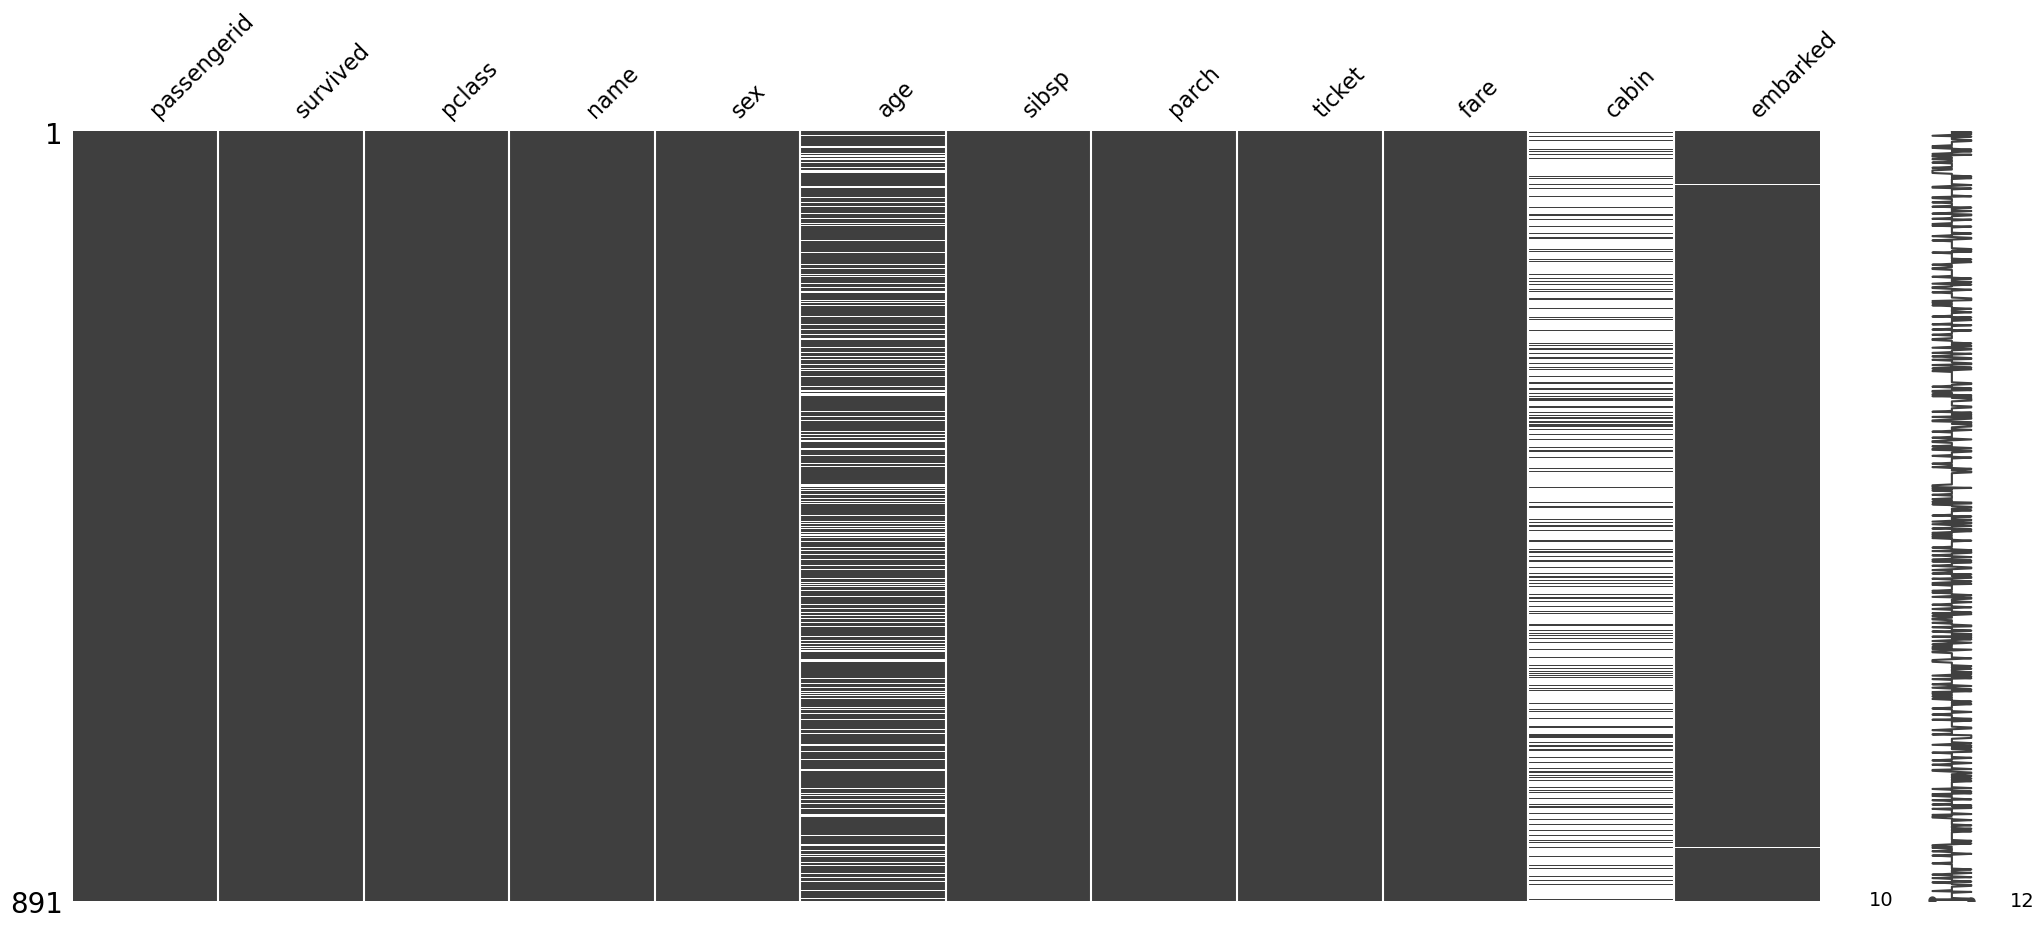

In [19]:
msno.matrix(df)

In [20]:
df.dtypes

passengerid      int64
survived         int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

In [21]:
df.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

### 4.1 Dealing with Missing Data

#### i. Fill The Missing Ages

In [22]:
# 1. Create a "Lookup Dictionary" from the training data
# This converts the medians into a simple python dict: {(1, 'male'): 40.0, ...}
median_dict = X_train.groupby(["pclass", "sex"])["age"].median().to_dict()

# 2. Define the function that works on a SINGLE ROW


def fill_age(row):
    # If age is missing (NaN), look it up
    if pd.isna(row["age"]):
        # Create a key tuple from this row's data
        key = (row["pclass"], row["sex"])
        # Return the median from our dict
        return median_dict.get(key, row["age"])

    # If age is already there, keep it
    return row["age"]


# 3. Apply it to all dataframes
# We assign the result back to the 'age' column
for df in [X_train, X_val, X_test]:
    df["age"] = df.apply(fill_age, axis=1)

In [23]:
df["age"].isna().sum()

np.int64(0)

In [24]:
df

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
455,456,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C
607,608,1,"Daniel, Mr. Robert Williams",male,27.0,0,0,113804,30.5000,NaN,S
142,143,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.8500,NaN,S
883,884,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
835,836,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,E49,C
...,...,...,...,...,...,...,...,...,...,...,...
322,323,2,"Slayter, Miss. Hilda Mary",female,30.0,0,0,234818,12.3500,NaN,Q
642,643,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S
566,567,3,"Stoytcheff, Mr. Ilia",male,19.0,0,0,349205,7.8958,NaN,S
690,691,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0000,B20,S


#### ii. Handle Cabin Missing Data (The Deck Approach)

In [25]:
# Applying this approach to X_train, X_val, X_test
for df in [X_train, X_val, X_test]:
    # Check if 'Cabin' exists to avoid errors (handles case sensitivity manually if needed)
    if "cabin" in df.columns:
        # Extract the first letter (Deck), fill NaN with 'U'
        df["deck"] = df["cabin"].str[0].fillna("U")

        # Drop the original high-cardinality Cabin Column
        df.drop(columns=["cabin"], inplace=True)
    else:
        print("Column 'cabin' not found. Check capitalization!")

In [26]:
df

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,deck
455,456,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,C,U
607,608,1,"Daniel, Mr. Robert Williams",male,27.0,0,0,113804,30.5000,S,U
142,143,3,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1,0,STON/O2. 3101279,15.8500,S,U
883,884,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,S,U
835,836,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,C,E
...,...,...,...,...,...,...,...,...,...,...,...
322,323,2,"Slayter, Miss. Hilda Mary",female,30.0,0,0,234818,12.3500,Q,U
642,643,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,S,U
566,567,3,"Stoytcheff, Mr. Ilia",male,19.0,0,0,349205,7.8958,S,U
690,691,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0000,S,B


<Axes: >

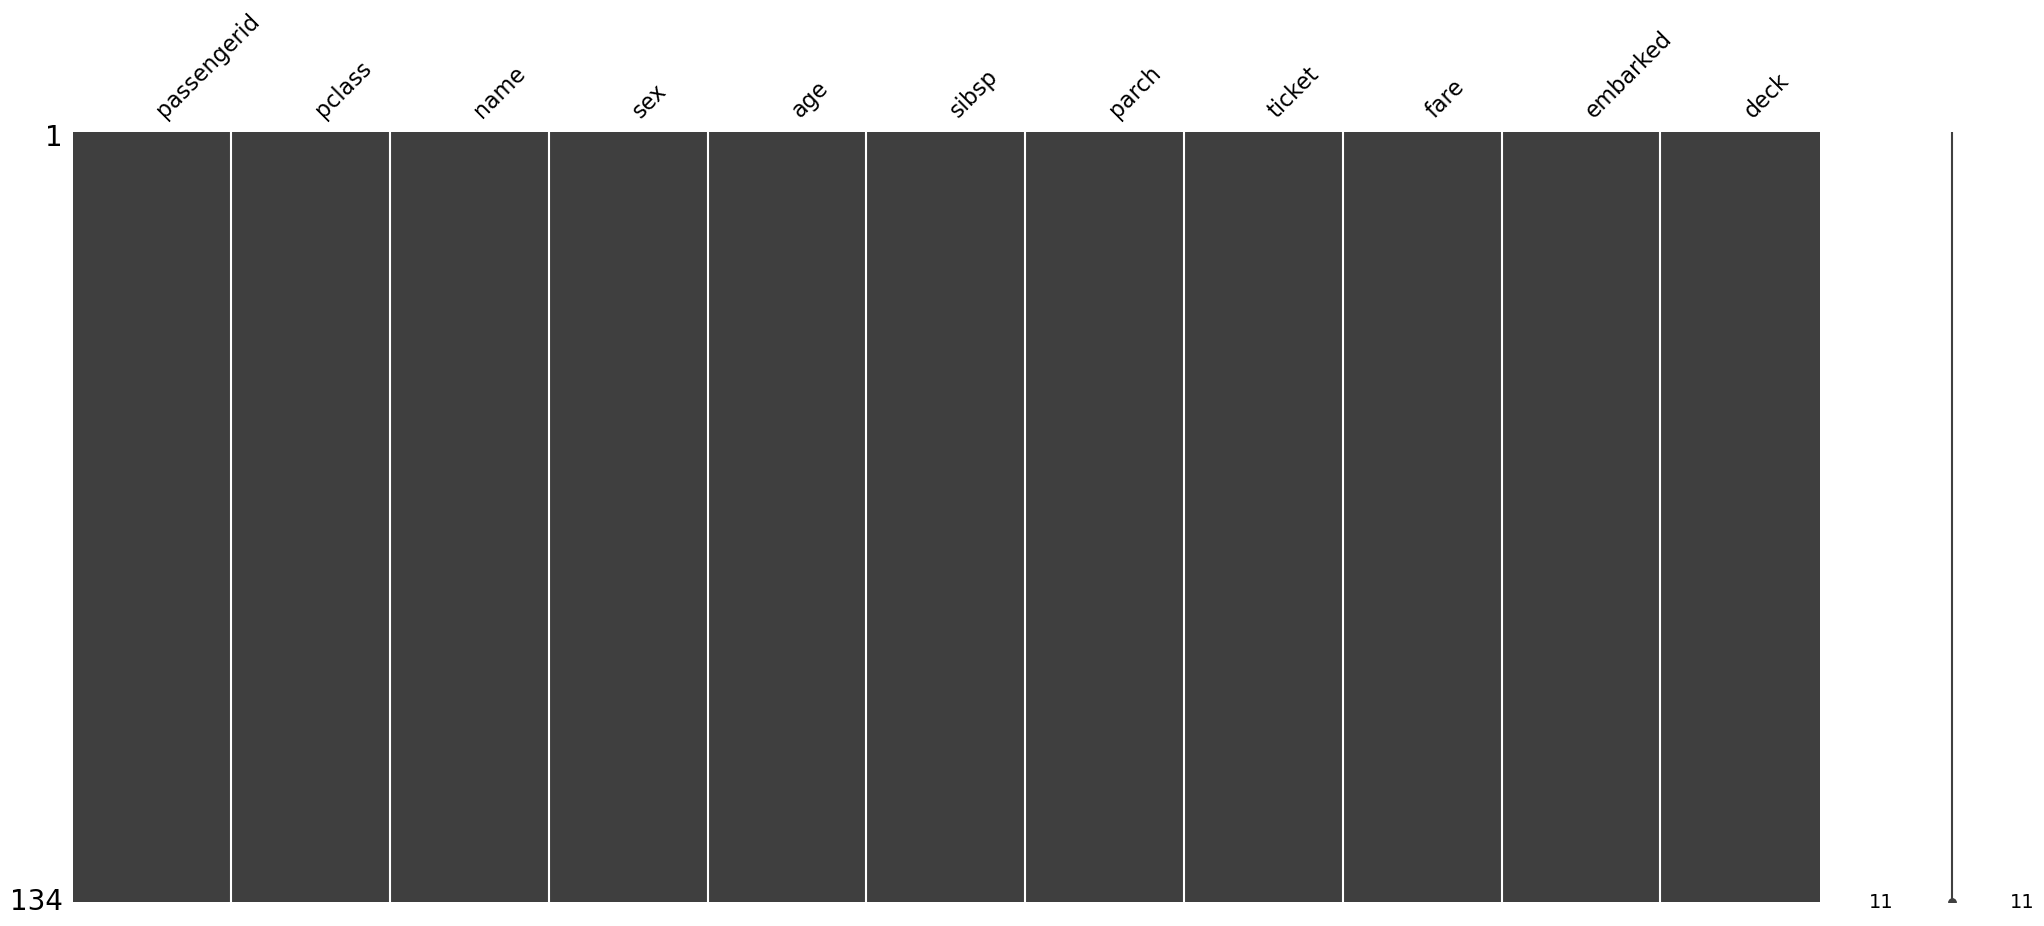

In [27]:
msno.matrix(df)

### iii. Visual on Deck

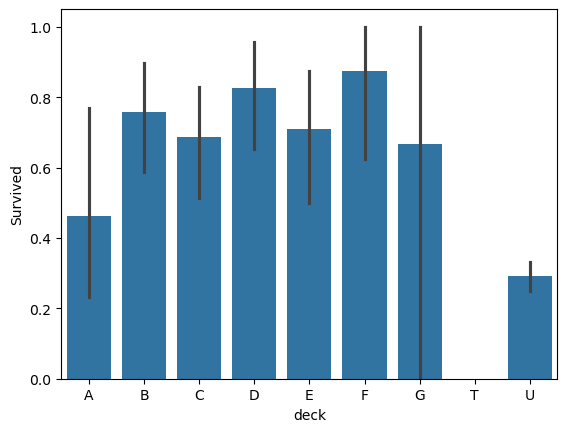

In [28]:
# 1. Create a temporary dataframe that joins X and y together
# Make sure to use the correct index so they align
plot_df = X_train.copy()
plot_df["Survived"] = y_train  # Add the target column back in

# 2. Now plot using this new dataframe
# Note: Check if your target column is named 'Survived' or 'survived'
sns.barplot(x="deck", y="Survived", data=plot_df, order=sorted(plot_df["deck"].unique()))
plt.show()

## 5. Save the Preprocessed Data

In [29]:
# 1. Define the directory path
save_dir = "../data/03-preprocessed"
os.makedirs(save_dir, exist_ok=True)

# 2. Save Features (X)
# index=False prevents pandas from adding that annoying 'Unnamed: 0' column
X_train.to_csv(f"{save_dir}/X_train_processed.csv", index=False)
X_val.to_csv(f"{save_dir}/X_val_processed.csv", index=False)
X_test.to_csv(f"{save_dir}/X_test_processed.csv", index=False)

# 3. Save Targets (y)
# We assume y_train, y_val exist from your train_test_split
y_train.to_csv(f"{save_dir}/y_train.csv", index=False)
y_val.to_csv(f"{save_dir}/y_val.csv", index=False)

print(f"Preprocessed data saved to {save_dir}/")

Preprocessed data saved to ../data/03-preprocessed/


## 6. Data Exploration

In [30]:
df.dtypes

passengerid      int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
embarked        object
deck            object
dtype: object

#### 6.1 Checking if behaviour of survivors was different from non-survivors

#### i. pclass - Ticket class, a proxy for socio-economic status (1=1st,2=2nd,3=3rd).

<Axes: xlabel='survived', ylabel='pclass'>

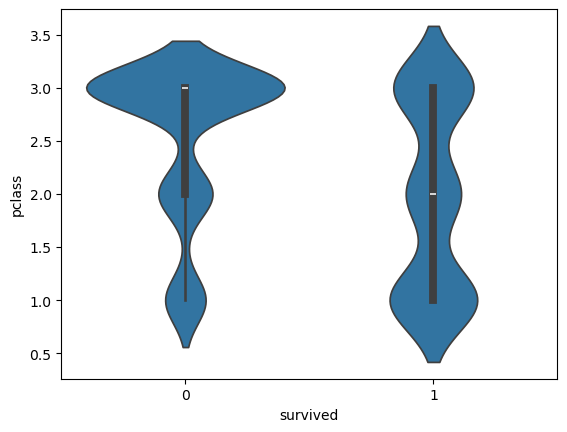

In [31]:
# Good for finding Outliers in pclass and seeing if Rich people survived
sns.violinplot(x="survived", y="pclass", data=X_train.join(y_train))

The **violin plot** reveals the "shape" and density of the data. It shows you where the largest "crowds" of passengers were located within each survival group.

### Breakdown of the Findings (Violin Plot)

**1\. Those Who Did Not Survive (survived = 0)**

*   **The "Bulge" at 3.0:** The widest part of the violin (the "belly") is concentrated heavily at the top (Class 3). This represents the massive volume of 3rd-class passengers who perished. Visually, it looks like a heavy weight at the top.
    
*   **The "Neck" at 1.0:** The violin tapers off into a very thin line at Class 1. This shows that while 1st-class passengers died, the density—or frequency—of those deaths was extremely low compared to the other classes.
    
*   **Distribution Shape:** It is "top-heavy." This indicates a skewed distribution where the majority of the data points are clustered at the lower social status/higher class number.
    

**2\. Those Who Survived (survived = 1)**

*   **The "Triple Bulge":** Unlike the non-survivor plot, the survivor violin often looks more like an hourglass or a more balanced cylinder. There are visible bulges at Class 1, Class 2, and Class 3.
    
*   **Concentration at 1.0:** You will notice a significant widening at the bottom (Class 1) that simply doesn't exist in the non-survivor plot. This visually represents the high survival rate of 1st-class passengers.
    
*   **The 3rd Class Paradox:** There is still a bulge at Class 3 for survivors. However, when compared to the non-survivor violin, you can see that a much smaller _proportion_ of the 3rd-class "mass" made it into this survivor shape.
    

### Summary Insights from the Density

*   **Density vs. Count:** The violin plot makes it obvious that death was a "crowded" event for 3rd class, but survival was a "distributed" event across all classes.
    
*   **Visual Skew:** You can immediately see the "social gradient." The non-survivor violin is essentially a pyramid pointing down (most deaths at the bottom/3rd class), while the survivor violin is much more vertically uniform.
    
*   **Probability at a Glance:** If you were to pick a random point in the "0" violin, you are statistically almost certain to land in the 3rd-class bulge. If you pick a point in the "1" violin, your chances are much more evenly spread across the three classes.

#### ii. Sex - Gender of the passenger.

<Axes: xlabel='sex', ylabel='survived'>

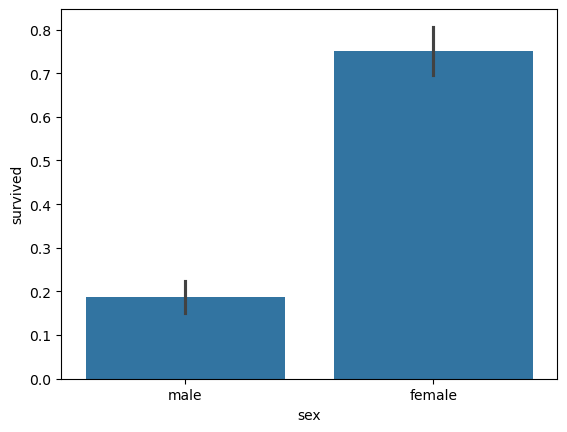

In [32]:
# Good for seeing if Females survived more
sns.barplot(x="sex", y="survived", data=X_train.join(y_train))

The Titanic survival rate by **Sex** is widely considered the most significant predictor in the entire dataset, even outweighing passenger class. This chart visually tells the story of the "women and children first" protocol.

### Breakdown of the Findings

**1\. Females (High Survival Density)**

*   **Survival Rate:** Approximately **74-75%** of women survived.
    
*   **Interpretation:** In almost any visualization of this data, the "Survived" bar for females will be significantly taller than the "Did Not Survive" bar. This reflects the priority given to women during the evacuation.
    
*   **Observation:** If this were a boxplot or violin plot, the "1" (survived) section would be much wider and denser than the "0" section.
    

**2\. Males (High Fatality Density)**

*   **Survival Rate:** Only about **18-19%** of men survived.
    
*   **Interpretation:** The vast majority of male passengers perished. This is shown by a dominant "Did Not Survive" bar. Most men remained on board while lifeboats were filled with women and children.
    
*   **Observation:** The "0" (did not survive) category for males usually represents the largest single group in the entire dataset.
    

### Summary Insights

*   **The Gender Gap:** The disparity is stark. Gender was a life-or-death factor, creating a clear "survival bias" toward female passengers.
    
*   **Predictive Strength:** Because this gap is so large, any machine learning model you build will likely identify Sex as the most important feature.
    
*   **Intersectionality:** While women had a higher survival rate overall, it's worth noting that a 1st-class male still had a lower survival probability than a 3rd-class female—further proving that gender was the primary filter for survival.

#### iii. Age - Age in years.

<Axes: xlabel='survived', ylabel='age'>

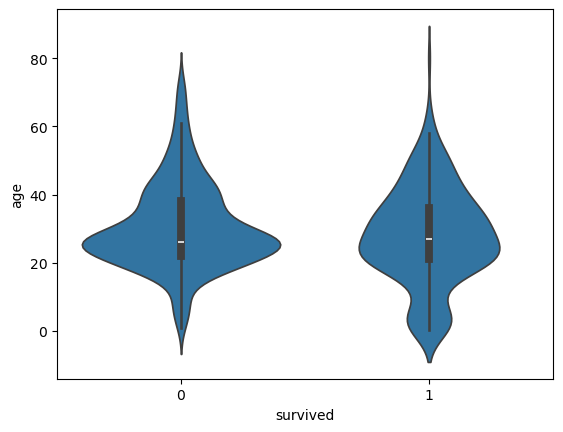

In [33]:
# Good for finding Outliers in age and seeing if it determined survival rate
sns.violinplot(x="survived", y="age", data=X_train.join(y_train))

Age vs Survival — Key Insights (Titanic Dataset)
------------------------------------------------

This violin plot compares the age distribution of passengers who **did not survive (0)** and those who **survived (1)**.

### 1\. Survival is higher among younger passengers

Passengers who survived tend to be **younger on average** than those who did not. The distribution for survivors is denser in the lower age ranges, particularly among children and young adults.

**Insight:** Age appears to be an important factor in survival, with younger passengers having a higher chance of surviving.

### 2\. Children had a clear survival advantage

The survivor group shows a noticeable concentration at very low ages (roughly 0–10 years), while this concentration is much smaller for non-survivors.

**Insight:** This supports the historical evacuation practice of _“women and children first”_ during the disaster.

### 3\. Middle-aged adults were less likely to survive

Passengers who did not survive are heavily concentrated in the **20–40 age range**, whereas the survivor distribution is less dense in this interval.

**Insight:** Middle-aged adults, especially men, were more likely to be among the fatalities.

### 4\. Older passengers had low survival rates

Both distributions thin out at higher ages (60+), but the survivor group thins out more sharply.

**Insight:** Survival probability decreases significantly with increasing age.

### 5\. Age alone is informative but not sufficient

Although age shows a clear relationship with survival, there is substantial overlap between the two distributions.

**Insight:** Age should not be used as a standalone predictor; it is best combined with other variables such as **sex**, **passenger class (Pclass)**, and **fare** for stronger predictive power.

#### iii. SibSp - Number of siblings or spouses aboard.

<Axes: xlabel='survived', ylabel='sibsp'>

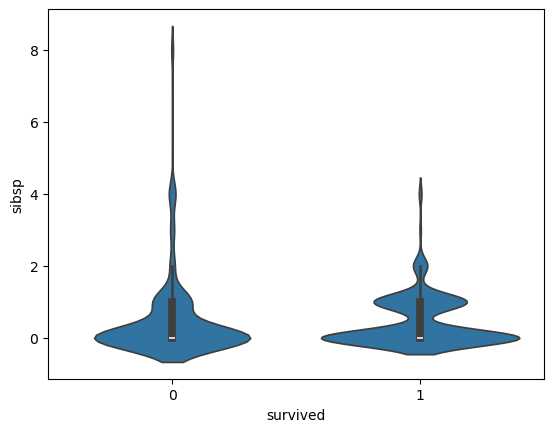

In [34]:
sns.violinplot(x="survived", y="sibsp", data=X_train.join(y_train))

Siblings/Spouses (SibSp) vs Survival — Key Insights
---------------------------------------------------

This violin plot shows the distribution of **siblings/spouses aboard (SibSp)** for passengers who **did not survive (0)** and those who **survived (1)**.

### 1\. Passengers traveling alone were common in both groups

Both survivors and non-survivors show a strong concentration at **SibSp = 0**, indicating that many passengers traveled alone.

**Insight:** Traveling alone does not guarantee survival or death, but it is the most common case overall.

### 2\. Small family groups had higher survival rates

Survivors are more densely concentrated around **SibSp = 1–2**, while non-survivors show less density in this range.

**Insight:** Passengers traveling with **one or two siblings/spouses** were more likely to survive than those traveling alone or in large family groups.

### 3\. Large family groups had lower survival rates

The non-survivor group exhibits a long tail with higher SibSp values (up to 8), whereas survivors rarely appear beyond **SibSp = 3–4**.

**Insight:** Passengers traveling with large families had a lower chance of survival, likely due to coordination difficulties during evacuation.

### 4\. Extremely high SibSp values are mostly associated with non-survivors

High SibSp counts are almost exclusively present in the non-survivor distribution.

**Insight:** Very large sibling/spouse groups faced a significant survival disadvantage.

### 5\. SibSp shows a non-linear relationship with survival

Survival is highest for **small family sizes**, not for zero or very large values.

**Insight:** SibSp is a useful feature, but its effect is **non-monotonic**, meaning simple linear assumptions may miss important patterns.

### Notebook takeaway

> **Passengers traveling with a small number of siblings or spouses (1–2) had better survival outcomes, while those traveling alone or in large family groups were less likely to survive.**

### Feature engineering note (optional but strong)

*   Consider creating a **FamilySize = SibSp + Parch + 1** feature.
    
*   Bin family size into categories such as:
    
    *   Alone
        
    *   Small (2–4)
        
    *   Large (5+)

#### iv. Parch -  Number of parents or children aboard.

<Axes: xlabel='survived', ylabel='parch'>

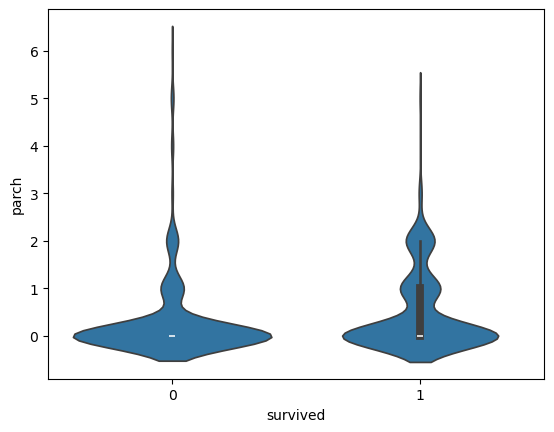

In [35]:
sns.violinplot(x="survived", y="parch", data=X_train.join(y_train))


### 1.Most passengers were alone

*   For both survivors (1) and non-survivors (0), the widest part of the violins is at **parch = 0**
    
*   This means **most people had no parents or children onboard**
    

**Interpretation:**Being alone was the norm on the Titanic.

### 2.Having parents/children is more common among survivors

*   The **survivor group** shows noticeably more density at:
    
    *   parch = 1
        
    *   parch = 2
        
*   The non-survivor group thins out faster above parch = 0
    

**Interpretation:**Passengers traveling with parents or children were **more likely to survive** than those traveling alone.

This aligns with:

*   evacuation priorities
    
*   families staying together
    
*   children being prioritized
    

### 3\. Very large families are rare and noisy

*   Both groups have long, thin tails at higher parch values
    
*   These cases are **very few**
    

**Interpretation:**High parch values exist, but:

*   they won’t strongly influence the model
    
*   treating them as-is is fine, but don’t overemphasize them
    

### 4\. parch alone is not a strong separator

*   There is **overlap** between the two violins
    
*   “If parch > X, then survived”
    

**Interpretation:**parch has **signal**, but it’s not a decisive feature on its own.

#### iv. Fare - The fare the passenger paid.

<Axes: xlabel='survived', ylabel='fare'>

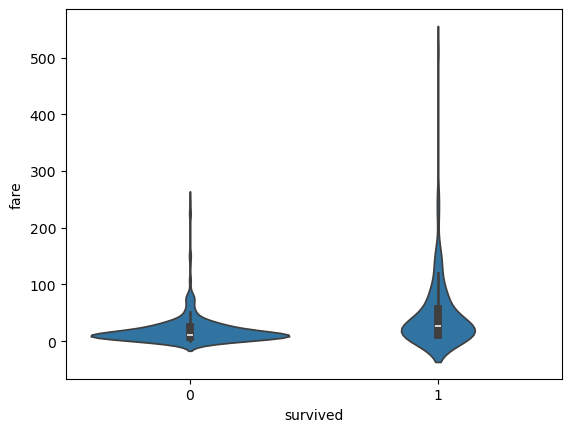

In [36]:
sns.violinplot(x="survived", y="fare", data=X_train.join(y_train))

**Fare vs Survival:**The violin plot shows that passengers who survived generally paid higher fares than those who did not. Survivors exhibit a wider fare distribution with a long upper tail, indicating that high-fare passengers were more likely to survive. In contrast, non-survivors are concentrated at lower fare values. This suggests that ticket price—often a proxy for passenger class and socioeconomic status—had a strong influence on survival outcomes.

#### v. Embarked

In [37]:
df["embarked"].unique()

array(['C', 'S', 'Q'], dtype=object)

<Axes: xlabel='embarked', ylabel='survived'>

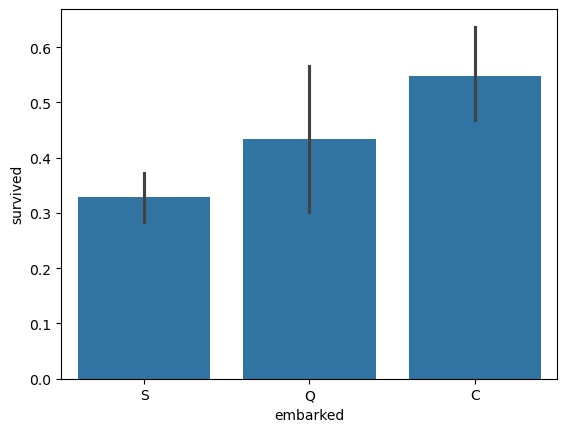

In [38]:
sns.barplot(x="embarked", y="survived", data=X_train.join(y_train))

## 7. Feature Engineering

## Family

We are going to take two confusing columns (SibSp and Parch) and turn them into two powerful new features: **FamilySize** and **IsAlone**.

### The Raw Data: What do we have?

Currently, your dataset has these two columns:

*   **SibSp**: The number of **Sib**lings (brothers/sisters) + **Sp**ouses (husband/wife) on board.
    
*   **Parch**: The number of **Par**ents + **Ch**ildren on board.
    

**The Problem:**Imagine a passenger named "John."

*   He has 1 wife with him (SibSp = 1).
    
*   He has 2 kids with him (Parch = 2).
    

To the model, these are just separate numbers. But to us humans, we know **John is traveling with a family of 4 people.** That is the "hidden" information we need to teach the model.

### Step 1: Create FamilySize

We want to know the total number of people in a passenger's group.

**The Math:**

FamilySize=SibSp+Parch+1

**Wait, why +1?** Because SibSp and Parch count the _relatives_. You need to add **+1** to include the passenger themselves!

**The Code:** Run this block. We apply it to X\_train, X\_val, and X\_test so all your data stays consistent.

In [39]:
# Create the 'FamilySize' column
for df in [X_train, X_val, X_test]:
    df["familysize"] = df["sibsp"] + df["parch"] + 1

# Let's verify it worked by looking at the first 5 rows
print(X_train[["sibsp", "parch", "familysize"]].head())

     sibsp  parch  familysize
748      1      0           2
45       0      0           1
28       0      0           1
633      0      0           1
403      1      0           2


### Step 2: Create IsAlone

This is a "Boolean" (True/False) feature.

**The Hypothesis:** People traveling alone were often young men looking for work (who were likely to die). People traveling with families were often women/children or wealthy fathers (who were likely to survive).

**The Logic:** If FamilySize is equal to 1, then the person is alone.

In [40]:
for df in [X_train, X_val, X_test]:
    df["isalone"] = (df["familysize"] == 1).astype(int)

# verify
print(X_train[["familysize", "isalone"]].head())

     familysize  isalone
748           2        0
45            1        1
28            1        1
633           1        1
403           2        0


### Step 3: Cleanup (The "Drop")

Now that we have FamilySize, the original SibSp and Parch columns are redundant. They are just "noise" now. It is cleaner to remove them.

In [41]:
# Drop the original columns to reduce clutter
cols_to_drop = ["sibsp", "parch", "FamilySize"]

for df in [X_train, X_val, X_test]:
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

print("Columns dropped successfully.")

Columns dropped successfully.


In [42]:
X_train

,passengerid,pclass,name,sex,age,ticket,fare,embarked,deck,familysize,isalone
748,749,1,"Marvin, Mr. Daniel Warner",male,19.0,113773,53.1000,S,D,2,0
45,46,3,"Rogers, Mr. William John",male,26.0,S.C./A.4. 23567,8.0500,S,U,1,1
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,22.0,330959,7.8792,Q,U,1,1
633,634,1,"Parr, Mr. William Henry Marsh",male,42.0,112052,0.0000,S,U,1,1
403,404,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,STON/O2. 3101279,15.8500,S,U,2,0
...,...,...,...,...,...,...,...,...,...,...,...
476,477,2,"Renouf, Mr. Peter Henry",male,34.0,31027,21.0000,S,U,2,0
190,191,2,"Pinsky, Mrs. (Rosa)",female,32.0,234604,13.0000,S,U,1,1
736,737,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,W./C. 6608,34.3750,S,U,5,0
462,463,1,"Gee, Mr. Arthur H",male,47.0,111320,38.5000,S,E,1,1


## Fare

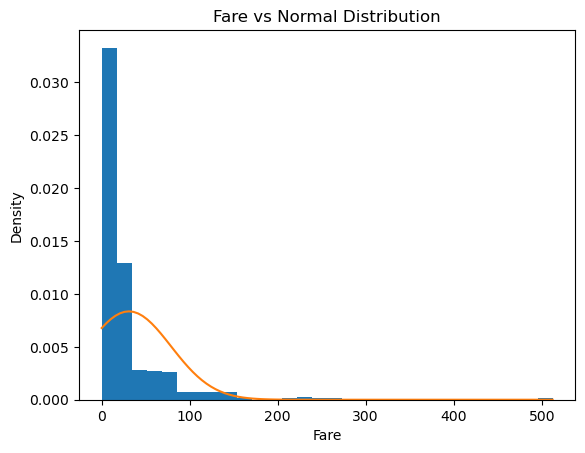

In [44]:
fare = X_train["fare"]
mu, sigma = fare.mean(), fare.std()

x = np.linspace(fare.min(), fare.max(), 100)
pdf = norm.pdf(x, mu, sigma)

plt.figure()
plt.hist(fare, bins=30, density=True)
plt.plot(x, pdf)
plt.xlabel("Fare")
plt.ylabel("Density")
plt.title("Fare vs Normal Distribution")
plt.show()

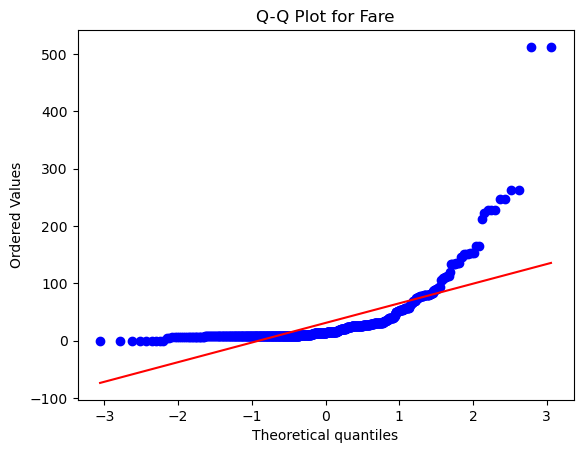

In [46]:
plt.figure()
stats.probplot(fare, dist="norm", plot=plt)
plt.title("Q-Q Plot for Fare")
plt.show()

### The Problem: "The Titanic Wealth Gap"

If you plot the fares, you will see that:

1.  **95% of passengers** paid less than $100.
    
2.  **A tiny handful** paid huge amounts (up to $512).
    

To a machine learning model, that $512 looks like a massive outlier/error compared to the $8 average. It stretches the math too far. We need to "squash" these huge numbers down so the model can learn better.

### Step 1: Fill Missing Values (Safety Check)

Before we do any math, we must ensure there are no empty slots. In the Titanic dataset, the Test set often has **one** passenger with a missing fare.

**The Fix:** Fill it with the median (the middle value). We use the median because the mean (average) is messed up by those rich billionaires.

In [47]:
# Calculate the median on TRAIN data only (to avoid cheating)
fare_median = X_train["fare"].median()

# 2. Fill missing value in all datasets
for df in [X_train, X_val, X_test]:
    df["fare"] = df["fare"].fillna(fare_median)

print(f"Filled missing fares with median: {fare_median}")

Filled missing fares with median: 13.5


### Step 2: The Log Transformation (The "Squash")

Now we fix the skewness. We will use a mathematical trick called a **Logarithm**.

*   It leaves small numbers (like $8) mostly alone.
    
*   It aggressively shrinks huge numbers (like $512 becomes ~6.2).
    

**Crucial Math Note:** You cannot take the Log of 0. Some people on the Titanic paid $0 (crew or special guests).Therefore, we use np.log1p which means **"Log of (1 + Fare)"**. This prevents the "Divide by Zero" crash.

In [48]:
# apply the log transformation to all datesets
for df in [X_train, X_val, X_test]:
    # This overwrites the old fare with the new 'log-transformed fare'
    df["fare"] = np.log1p(df["fare"])

print("Fare column successfully log-transformed.")

Fare column successfully log-transformed.


### Step 3: Verify the Fix (Visual Check)

You should always trust but verify. Let's look at what we just did.

Run this code to compare the "Before" (which you can't see anymore, but imagine it) vs the "After".

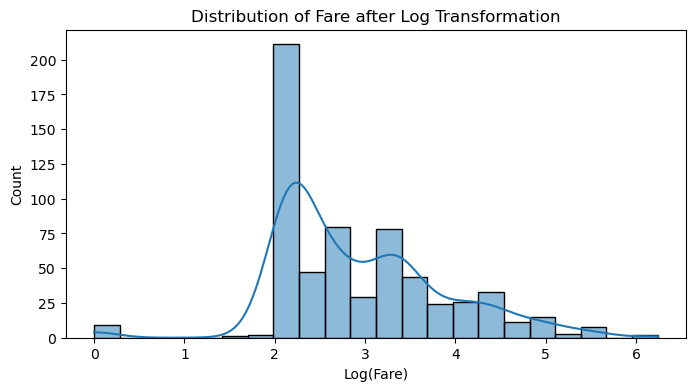

In [49]:
# Plot the new Distribution
plt.figure(figsize=(8, 4))
sns.histplot(X_train["fare"], kde=True)
plt.title("Distribution of Fare after Log Transformation")
plt.xlabel("Log(Fare)")
plt.show()

## Names

Right now, the name column looks like this: _"Braund, Mr. Owen Harris"_.To a computer, that is just random text. It doesn't know that **"Mr"** means an adult man (who likely died) and **"Master"** means a little boy (who likely lived).

If we skip this, your model will miss out on the strongest predictor of survival for males.

Let's Feature Engineer **Titles** from Names step-by-step.

### Step 1: Extract the Title

We need to pull out the word that comes after the comma and ends with a dot (e.g., Mr., Mrs., Dr.).

In [50]:
# 1. Extract the title from the Name column
for df in [X_train, X_val, X_test]:
    # The regex ' ([A-Za-z]+)\.' looks for words ending in a dot
    df["title"] = df["name"].str.extract(" ([A-Za-z]+)\.", expand=False)

# Let's see what we found
print(X_train["title"].value_counts())

title
Mr          364
Miss        122
Mrs          91
Master       26
Dr            6
Rev           5
Col           2
Mlle          2
Major         1
Lady          1
Jonkheer      1
Don           1
Sir           1
Name: count, dtype: int64


### Step 2: Group the "Rare" Titles

Having a category with only 1 person (like "Jonkheer") confuses the model. We need to group these rare titles into a single category called **"Rare"** (or map them to their closest standard title).

**The Strategy:**

*   **Mr, Miss, Mrs, Master:** Keep these.
    
*   **Mlle, Ms:** Convert to **Miss**.
    
*   **Mme:** Convert to **Mrs**.
    
*   **Dr, Rev, Col, Major, Don, etc.:** Group as **Rare**.

In [51]:
# Define the mapping dictionary
title_mapping = {
    "Mr": "Mr",
    "Miss": "Miss",
    "Mrs": "Mrs",
    "Master": "Master",
    "Dr": "Rare",
    "Rev": "Rare",
    "Col": "Rare",
    "Major": "Rare",
    "Mlle": "Miss",
    "Countess": "Rare",
    "Ms": "Miss",
    "Lady": "Rare",
    "Jonkheer": "Rare",
    "Don": "Rare",
    "Dona": "Rare",
    "Mme": "Mrs",
    "Capt": "Rare",
    "Sir": "Rare",
}

# Apply the mapping
for df in [X_train, X_val, X_test]:
    df["title"] = df["title"].map(title_mapping)
    # Fill any we missed with "Rare" just in case
    df["title"] = df["title"].fillna("Rare")

print("Titles grouped successfully!")
print(X_train["title"].value_counts())

Titles grouped successfully!
title
Mr        364
Miss      124
Mrs        91
Master     26
Rare       18
Name: count, dtype: int64


### Step 3: Drop the original Name column

Now that we have the title, the full name is just noise.

In [52]:
cols_to_drop = ["name", "passengerid"]  # We also drop PassengerId now as it's useless

for df in [X_train, X_val, X_test]:
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

print("Name and PassengerId dropped.")

Name and PassengerId dropped.


## Embarked

### The Problem: Missing Data

In the training set, two passengers are missing their port of embarkation. We can't leave these empty, or the model will crash.

### The Solution: "Follow the Crowd" (Mode Imputation)

Since we only have 2 missing values, the safest statistical guess is to assume they boarded at the most popular port.

If you look at the data, the vast majority of people boarded at **Southampton (S)**.

Therefore, we will fill the missing spots with 'S'.

In [53]:
# 1. Find the most common port in the TRAIN set
# .mode() returns a series, so we take the first item [0]
embarked_mode = X_train["embarked"].mode()[0]

print(f"Most common port is: {embarked_mode}")

# 2. Fill missing values in all datasets
for df in [X_train, X_val, X_test]:
    df["embarked"] = df["embarked"].fillna(embarked_mode)

print("Embarked column successfully filled.")

Most common port is: S
Embarked column successfully filled.


In [54]:
X_train.dtypes

pclass          int64
sex            object
age           float64
ticket         object
fare          float64
embarked       object
deck           object
familysize      int64
isalone         int64
title          object
dtype: object

## Tickets

#### Step 1: The Logic 

We want to extract the first part of the ticket.

    A/5 21171 → Prefix: A5

    PC 17599 → Prefix: PC

    113803 (Just numbers) → Prefix: X (No Prefix)**

In [56]:
# 1. Define the cleaning function


def clean_ticket(ticket):
    ticket = str(ticket)
    if ticket.isdigit():
        return "X"  # Represents "No Prefix" (just numbers)
    else:
        # Get the first part (prefix), remove '.' and '/'
        prefix = ticket.split(" ")[0]
        prefix = prefix.replace(".", "").replace("/", "")
        return prefix


# 2. Apply it to all datasets
for df in [X_train, X_val, X_test]:
    df["TicketPrefix"] = df["ticket"].apply(clean_ticket)

# Let's see what we found
print("Top 10 Ticket Prefixes found:")
print(X_train["TicketPrefix"].value_counts().head(10))

Top 10 Ticket Prefixes found:
TicketPrefix
X          453
PC          49
CA          27
A5          16
SOTONOQ     11
STONO       10
WC           9
A4           6
C            5
SCPARIS      4
Name: count, dtype: int64


### Step 2: Grouping "Rare" Prefixes

You will likely see many prefixes that only appear once or twice (like SP, SOP). These will confuse the model.

We need to group any prefix with fewer than 10 occurrences into a **"Rare\_Ticket"** category.

In [57]:
# 1. Calculate frequency of each prefix in TRAINING set
prefix_counts = X_train["TicketPrefix"].value_counts()

# 2. Create a list of "Rare" prefixes (those appearing less than 10 times)
# You can adjust the threshold (10) if you want
rare_prefixes = prefix_counts[prefix_counts < 10].index

# 3. Replace them with 'Rare_Ticket'
for df in [X_train, X_val, X_test]:
    # If the prefix is in our "rare" list, rename it
    df.loc[df["TicketPrefix"].isin(rare_prefixes), "TicketPrefix"] = "Rare_Ticket"

print("Rare tickets grouped.")
print(X_train["TicketPrefix"].value_counts())

Rare tickets grouped.
TicketPrefix
X              453
Rare_Ticket     57
PC              49
CA              27
A5              16
SOTONOQ         11
STONO           10
Name: count, dtype: int64


### Step 3: Drop the Original & Encode

Now that we have the clean TicketPrefix column, the original ticket column is useless.

**Important:** Since TicketPrefix is text (Categorical), we must add it to your One-Hot Encoding list.

In [58]:
# 1. Drop the original messy ticket column
for df in [X_train, X_val, X_test]:
    df.drop(columns=["ticket"], inplace=True, errors="ignore")

# 2. One-Hot Encode the NEW 'TicketPrefix' column
# We do this separately since you already encoded the other columns
prefix_dummies_train = pd.get_dummies(X_train["TicketPrefix"], prefix="Ticket", drop_first=True)
prefix_dummies_val = pd.get_dummies(X_val["TicketPrefix"], prefix="Ticket", drop_first=True)
prefix_dummies_test = pd.get_dummies(X_test["TicketPrefix"], prefix="Ticket", drop_first=True)

# 3. Join them back to your main dataframes
X_train = pd.concat([X_train, prefix_dummies_train], axis=1)
X_val = pd.concat([X_val, prefix_dummies_val], axis=1)
X_test = pd.concat([X_test, prefix_dummies_test], axis=1)

# 4. Drop the temporary 'TicketPrefix' text column
X_train.drop(columns=["TicketPrefix"], inplace=True)
X_val.drop(columns=["TicketPrefix"], inplace=True)
X_test.drop(columns=["TicketPrefix"], inplace=True)

# 5. ALIGN COLUMNS (Crucial Step!)
# Ensure Val/Test have exactly the same columns as Train
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"Ticket feature engineering complete. Total columns: {X_train.shape[1]}")

Ticket feature engineering complete. Total columns: 15


In [ ]:
X_train

## One hot Encoding

**The Concept:**Machine learning models are mathematical equations. They can't multiply "male" by 5.One-Hot Encoding creates a new binary column (0 or 1) for every category.

*   sex becomes: sex\_male (0 or 1) and sex\_female (0 or 1).
    
*   embarked becomes: embarked\_S, embarked\_C, embarked\_Q.
    

### The "Hidden Trap" (Column Mismatch)

Here is where 90% of beginners crash their model.

Imagine your Training set has a passenger with **Deck T**, but your Test set _doesn't_.

*   X\_train will have a column deck\_T.
    
*   X\_test will **missing** that column.
    
*   **Result:** The model will crash during prediction because it expects deck\_T to exist.
    

We will fix this using a technique called **"Aligning Columns"**.

### Handling pclass First

Since we want to try **multiple models** to find the best one (including Linear Regression or Neural Networks), **One-Hot Encoding** is safer. It prevents the linear models from making bad assumptions.

Because pandas sees 1, 2, 3 as integers, get\_dummies will **ignore** pclass by default unless we force it.

In [61]:
import pandas as pd

# 1. Cast Pclass to string (ONLY if it exists)
# This prevents the KeyError if you run the cell multiple times
for df in [X_train, X_val, X_test]:
    if "pclass" in df.columns:
        df["pclass"] = df["pclass"].astype(str)

# 2. Define the list of columns we WANT to encode
target_categorical_cols = ["pclass", "sex", "embarked", "title", "deck", "TicketPrefix"]

# 3. Filter the list: Only encode columns that actually EXIST right now
# This is the "Idempotent" magic. If 'pclass' is gone, it won't try to encode it again.
existing_cols = [col for col in target_categorical_cols if col in X_train.columns]

if existing_cols:
    print(f"Encoding the following columns: {existing_cols}")

    # 4. Apply One-Hot Encoding
    X_train = pd.get_dummies(X_train, columns=existing_cols, drop_first=True)
    X_val = pd.get_dummies(X_val, columns=existing_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=existing_cols, drop_first=True)

    # 5. ALIGN COLUMNS
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # 6. Fix Booleans
    for df in [X_train, X_val, X_test]:
        for col in df.columns:
            if df[col].dtype == "bool":
                df[col] = df[col].astype(int)

    print(" One-Hot Encoding complete.")
else:
    print("No categorical columns found. (They might already be encoded!)")

print(f"Total Features: {X_train.shape[1]}")
print(X_train.head())

No categorical columns found. (They might already be encoded!)
Total Features: 27
      age      fare  familysize  isalone  Ticket_CA  Ticket_PC  \
748  19.0  3.990834           2        0          0          0   
45   26.0  2.202765           1        1          0          0   
28   22.0  2.183711           1        1          0          0   
633  42.0  0.000000           1        1          0          0   
403  28.0  2.824351           2        0          0          0   

     Ticket_Rare_Ticket  Ticket_SOTONOQ  Ticket_STONO  Ticket_X  ...  \
748                   0               0             0         1  ...   
45                    1               0             0         0  ...   
28                    0               0             0         1  ...   
633                   0               0             0         1  ...   
403                   1               0             0         0  ...   

     title_Mrs  title_Rare  deck_B  deck_C  deck_D  deck_E  deck_F  deck_G  \
748       

## Saving the Data

**Save BEFORE Scaling.**

### Why? (The "Two-Model" Problem)

You are about to enter the **Model Selection** phase where you will test different algorithms. They have different needs:

1.  **Tree Models (Random Forest, XGBoost):** They **do not** need scaling. In fact, keeping the original numbers (Age=22 vs Age=0.45) makes the model easier to interpret ("People under Age 10 survived" vs "People under 0.12 std deviation survived").
    
2.  **Linear/Neural Models (Logistic Regression, Neural Networks):** They **REQUIRE** scaling.
    

If you save the data _after_ scaling, you "corrupt" the dataset for your Tree models, making them harder to explain.

### The Strategy

1.  **Save the Encoded (Unscaled) Data now.** This is your "Master" processed dataset.
    
2.  **Load this Master dataset** in your training notebooks.
    
    *   If training Random Forest -> Use as is.
        
    *   If training Neural Network -> Apply the scaler (which you saved as a .pkl) on the fly.

In [62]:
# 1. Define save path
save_dir = "../data/04-encoded"  # Distinct folder for this version
os.makedirs(save_dir, exist_ok=True)

# 2. Save the datasets
X_train.to_csv(f"{save_dir}/X_train_encoded.csv", index=False)
X_val.to_csv(f"{save_dir}/X_val_encoded.csv", index=False)
X_test.to_csv(f"{save_dir}/X_test_encoded.csv", index=False)

# Don't forget y! (Targets haven't changed, but good to keep them together)
y_train.to_csv(f"{save_dir}/y_train.csv", index=False)
y_val.to_csv(f"{save_dir}/y_val.csv", index=False)

print(f"Master Encoded Data saved to {save_dir}")
print("   (Use this for Random Forest / XGBoost)")

Master Encoded Data saved to ../data/04-encoded
   (Use this for Random Forest / XGBoost)
